# Group Assignment #4: Spatial Analysis
Group members: Tiffany Feng and Emily DiPressi

## Libraries

In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Datasets

In [2]:
# load a data files
population = gpd.read_file('acs2019_1yr_B01003_04000US46.geojson')

kids_spend = pd.read_csv('us_spending_kids.csv')

### Data Wrangling

In [3]:
# rename state name column to match in both datasets so that I can merge together:
population.rename(columns = {'name':'state'}, inplace=True)

# drop the row with index 0 (first row) as it is at a different scale
population1 = population.drop([0])

# inf_adj is raw adjusted for inflation
# the definitions of the variable values are found in the Data folder

# merge the data into one data set:
spending_pop = pd.merge(population, kids_spend, on='state')
spending_pop.head()

,geoid,state,B01003001,"B01003001, Error",geometry,variable,year,raw,inf_adj,inf_adj_perchild
0,04000US01,Alabama,4903185.0,0.0,"MULTIPOLYGON (((-88.13999 34.58170, -88.13997 ...",PK12ed,1997,3271969.000,4.665308e+06,3.929449
1,04000US01,Alabama,4903185.0,0.0,"MULTIPOLYGON (((-88.13999 34.58170, -88.13997 ...",highered,1997,956505.000,1.363824e+06,1.148708
2,04000US01,Alabama,4903185.0,0.0,"MULTIPOLYGON (((-88.13999 34.58170, -88.13997 ...",edsubs,1997,107733.000,1.536102e+05,0.129381
3,04000US01,Alabama,4903185.0,0.0,"MULTIPOLYGON (((-88.13999 34.58170, -88.13997 ...",edservs,1997,246057.000,3.508382e+05,0.295500
4,04000US01,Alabama,4903185.0,0.0,"MULTIPOLYGON (((-88.13999 34.58170, -88.13997 ...",pell,1997,120833.258,1.722890e+05,0.145114


## Mapping

### Preparing for Mapping

In [4]:
# subset just certain rows:
pk12ed_data = spending_pop[spending_pop['variable'] == 'PK12ed']

pk12ed_data2 = pk12ed_data.to_crs('esri:102003')

pk12ed_2016 = pk12ed_data2[pk12ed_data2['year'] == 2016]

# pk12ed_1997 = pk12ed_data2[pk12ed_data2['year'] == 1997]

### Mapping

Text(0.5, 1.0, '2016 Elementary & Secondary Education Expenditures Per Child by State')

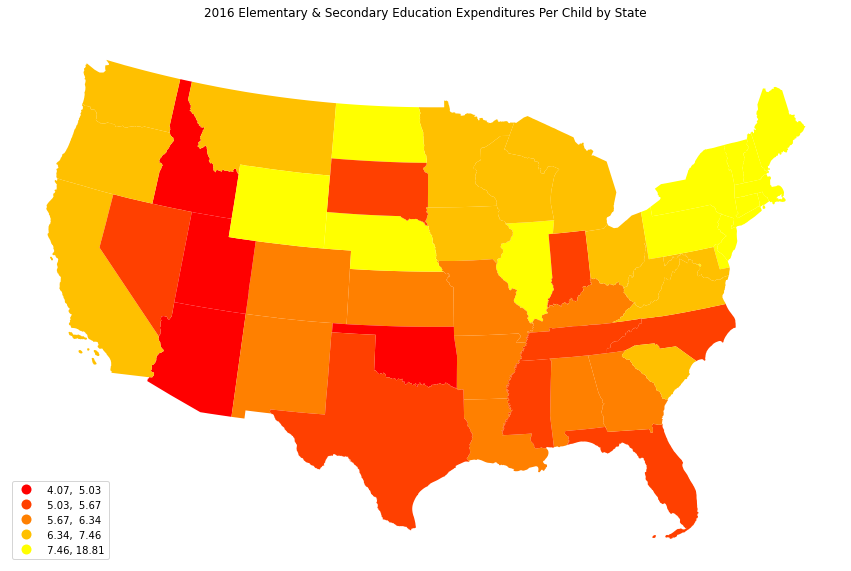

In [5]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 1, figsize=(15, 12))

xlim = (-2600000,2500000)
ylim = (-1500000,1800000)

# name each subplot
ax1 = axs

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

import mapclassify
bins = mapclassify.Quantiles(pk12ed_data2['inf_adj_perchild'], k=5).bins

pk12ed_2016.plot(figsize=(30,40),
                 column='inf_adj_perchild',
                 cmap = 'autumn',
                 legend=True,
                 legend_kwds={'loc': 'lower left'},
                 ax=ax1,
                 scheme='user_defined',
                 classification_kwds=dict(bins=bins))

ax1.axis("off")
ax1.set_title("2016 Elementary & Secondary Education Expenditures Per Child by State")


This map shows the spending in each state for elementary and secondary education per child in 2016. The red indicates low spending and the yellow is high spending per child. Coastal cities have higher spending, whereas central and southern states are on the low end.

## Moran's Plot 

In [6]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(pk12ed_2016,k=4) # we are considering 4 neighbors

y = pk12ed_2016.inf_adj_perchild
moran = Moran(y, wq)
moran.I

0.4465223841645343

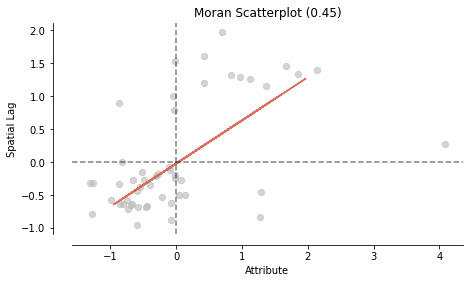

In [7]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

We found our Moran value for our scatter plot for our variable on spending per child for elementary and secondary education which is 0.45. Since it is a positive number, this indicates a positive spatial autocorrelation, this means high values are close to high vlaues and low values are close to low values. 

We wanted to find out the significance of our Moran value. In other words, how likely is our observed pattern on the map generated by an entirely random process?

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07fcd15e80>)

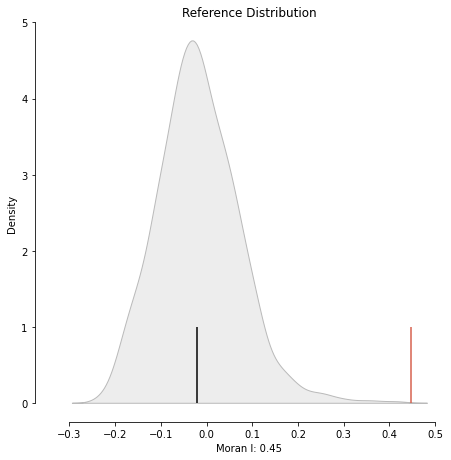

In [8]:
plot_moran_simulation(moran,aspect_equal=False)

In [9]:
moran.p_sim

0.001

This is a low value. If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.1% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.9% of the random maps would receive a smaller (absolute) value of Moran’s I. In conclusion, we believe our data is not due to random chance. 

## Moran Local Scatterplot

Next, we want to explore clusters on spending per child for elementary and secondary education. Local Indicators of Spatial Association (LISA) is used to do that. We will use LISA to classify our data. 

- HH: high spending per child states near other high spending per child states
- LL: low spending per child states near other low spending per child states
- LH (donuts): low spending per child states surrounded by high spending per child states
- HL (diamonds): high spending per child states surrounded by low spending per child states

In [10]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

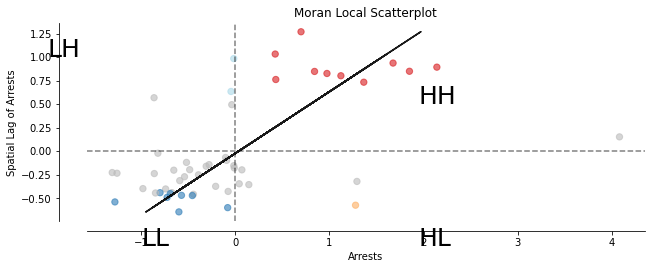

In [11]:
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Arrests")
ax.set_ylabel('Spatial Lag of Arrests')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

In the scatterplot above, the colored dots represents the rows (states) that have a P-value less that 0.05 in each quadrant. In other words, these are the statisticaly significantly, spatially autocorrelated states.

## Spatial Autocorrelation Map

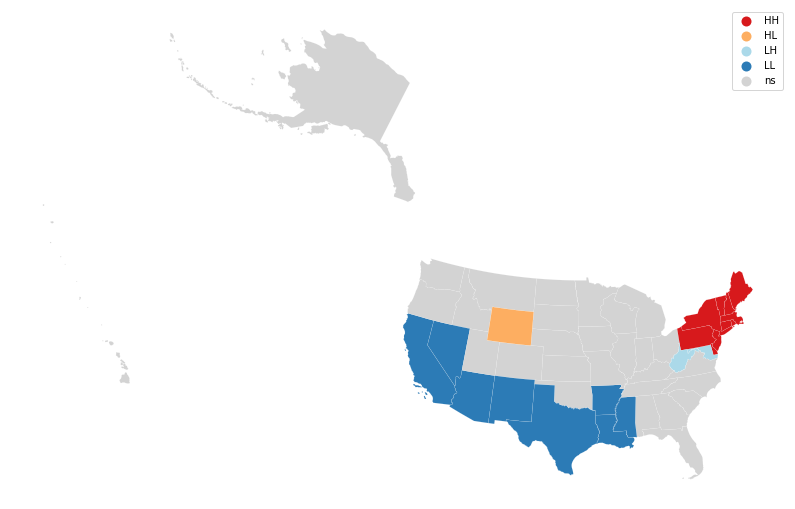

In [12]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, pk12ed_2016, p=0.05, ax=ax)
plt.show()

This map shows that there is a majority of LL (low spending surrounded by low spending states) along the border of the US from California to Mississippi and HH (high spending surrounded by high spending states) in the Northeastern part of the US. There is one diamond (Wyoming) in the central US and two donuts (Maryland and West Virginia). 

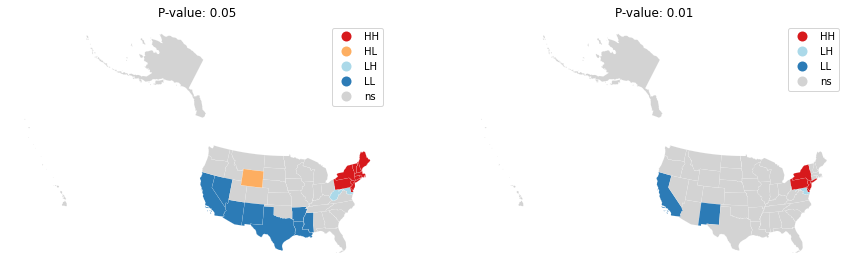

In [13]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# pval of 0.05
lisa_cluster(lisa, pk12ed_2016, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# pval of 0.01
lisa_cluster(lisa, pk12ed_2016, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

California and New Mexico are still significant at a low p-value. New York, Pennsylvania, and New Jersey are still significant at a low p-value. For CA and NM they are still LL (low spending per child states near other low spending per child states) and NJ, PA, NY are also still HH (high spending per child states near other high spending per child states). 

* Emily DiPressi: interpreted code with Tiffany. 
* Tiffany Feng: created and ran code and interpreted code. 